###  Importing Vanna modules

This cell imports the main components needed to use Vanna:
- `Ollama` to connect with local LLMs like mistral or llama3.
- `ChromaDB_VectorStore` to store and retrieve question-SQL pairs.
- `SQLite_Connector` to connect to a local SQLite database.


In [ ]:
from vanna.ollama import Ollama
from vanna.chromadb import ChromaDB_VectorStore
from vanna.sqlite import SQLite_Connector

###  Setting up a custom Vanna class

This cell defines a custom Vanna class that combines both the ChromaDB vector store and the Ollama LLM backend.  
We then create an instance of this class using the `mistral` model to handle natural language to SQL conversion.


In [ ]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

vn = MyVanna(config={'model': 'mistral'}) 9a6948db-8fd0-41c2-bc20-bf89f09f0cf8

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


###  Creating the SQLite database and adding sample data

This cell sets up a local SQLite database named `test.db`, creates a `customers` table if it doesn't exist, and inserts a few sample records.  
These dummy entries will be used to test the natural language to SQL generation later.


In [ ]:
import sqlite3

conn = sqlite3.connect("test.db")
cursor = conn.cursor() 

cursor.execute("""
CREATE TABLE IF NOT EXISTS customers (
    id INTEGER PRIMARY KEY,
    name TEXT,
    age INTEGER,
    country TEXT,
    total_spent REAL
)
""")

sample_data = [
    (1, "John Doe", 45, "Egypt", 12000),
    (2, "Alice Smith", 33, "USA", 5000),
    (3, "Mohamed Salah", 50, "Egypt", 18000),
    (4, "Sarah Ahmed", 29, "Egypt", 3000),
    (5, "Bob Brown", 60, "UK", 7000)
]

cursor.executemany("INSERT OR REPLACE INTO customers VALUES (?, ?, ?, ?, ?)", sample_data)
conn.commit()
conn.close()


###  Defining the schema documentation

This is a natural language description of the `customers` table.  
It explains each column and also defines what qualifies a customer as a "VIP".  
This context will be passed to the LLM to improve the accuracy of SQL generation.


In [ ]:
schema_doc = """
We have a table called 'customers' with the following columns:
- id: unique customer ID
- name: full name of the customer
- age: age of the customer
- country: customer's country
- total_spent: total money the customer spent

VIP customers are those who spent more than 10000 or are over 50 years old.
"""


###  Note on the custom modification inside `generate_sql`

Normally, Vanna expects schema or business documentation to be passed using the `.train(documentation=...)` method.  
However, in this project, I modified the internal `generate_sql` method inside Vanna's source code (`base.py`) to accept a new parameter (`extra_doc`).

This allows me to inject a natural language description of the database (like `schema_doc`) **on-the-fly**, without needing to retrain the model each time.

This is useful when:
- You want to use Vanna statelessly (e.g. in notebooks or APIs).
- Your database schema is dynamic or changes frequently.
- You prefer to pass context per-query instead of persisting it.

The `extra_doc` is merged with the prompt before being sent to the LLM, improving SQL generation accuracy without relying on stored training sessions.


In [ ]:
sql = vn.generate_sql(
    question="Show me the VIP customers from Egypt",
    extra_doc=schema_doc
)


print("Generated SQL:\n", sql)

Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


SQL Prompt: [{'role': 'system', 'content': "You are a SQL expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \n\n    CREATE TABLE customers (\n        id INT PRIMARY KEY,\n        name VARCHAR(100),\n        age INT,\n        country VARCHAR(50)\n    );\n\n\n\n===Additional Context \n\n\n    In our business, a VIP customer is someone whose age is over 40 and who lives in Egypt.\n\n\n\nWe have a table called 'customers' with the following columns:\n- id: unique customer ID\n- name: full name of the customer\n- age: age of the customer\n- country: customer's country\n- total_spent: total money the customer spent\n\nVIP customers are those who spent more than 10000 or are over 50 years old.\n\n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question. \n2. If t

###  Connecting Vanna to the SQLite database

Here we connect Vanna to our local SQLite database (`test.db`) so that generated SQL queries can be executed directly on it.


In [6]:
vn.connect_to_sqlite("test.db")


###  Asking a question using Vanna's `ask()` method

Here we use `vn.ask()` to send a natural language question to Vanna.  
Under the hood, this method generates the SQL query, executes it on the connected SQLite database, and returns the final result.  
In this case, we're asking for VIP customers from Egypt.


Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


SQL Prompt: [{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE customers (\n    id INTEGER PRIMARY KEY,\n    name TEXT,\n    age INTEGER,\n    country TEXT,\n    total_spent REAL\n)\n\n\n    CREATE TABLE customers (\n        id INT PRIMARY KEY,\n        name VARCHAR(100),\n        age INT,\n        country VARCHAR(50)\n    );\n\n\n\n===Additional Context \n\n\n    In our business, a VIP customer is someone whose age is over 40 and who lives in Egypt.\n\n\n===Response Guidelines \n1. If the provided context is sufficient, please generate a valid SQL query without any explanations for the question. \n2. If the provided context is almost sufficient but requires knowledge of a specific string in a particular column, please generate an intermediate SQL query to find the distinct string

Failed to send telemetry event CollectionAddEvent: capture() takes 1 positional argument but 3 were given


Info: Ollama Response:
model='mistral:latest' created_at='2025-07-01T12:08:53.6805272Z' done=True done_reason='stop' total_duration=46415693200 load_duration=37889600 prompt_eval_count=379 prompt_eval_duration=41855000000 eval_count=21 eval_duration=4511000000 message=Message(role='assistant', content=" SELECT * FROM customers WHERE country = 'Egypt' AND age > 40;", thinking=None, images=None, tool_calls=None)
LLM Response:  SELECT * FROM customers WHERE country = 'Egypt' AND age > 40;
Info: Output from LLM:  SELECT * FROM customers WHERE country = 'Egypt' AND age > 40; 
Extracted SQL: SELECT * FROM customers WHERE country = 'Egypt' AND age > 40
SELECT * FROM customers WHERE country = 'Egypt' AND age > 40
   id           name  age country  total_spent
0   1       John Doe   45   Egypt      12000.0
1   3  Mohamed Salah   50   Egypt      18000.0
Info: Ollama parameters:
model=mistral:latest,
options={},
keep_alive=None
Info: Prompt Content:
[{"role": "system", "content": "The following i

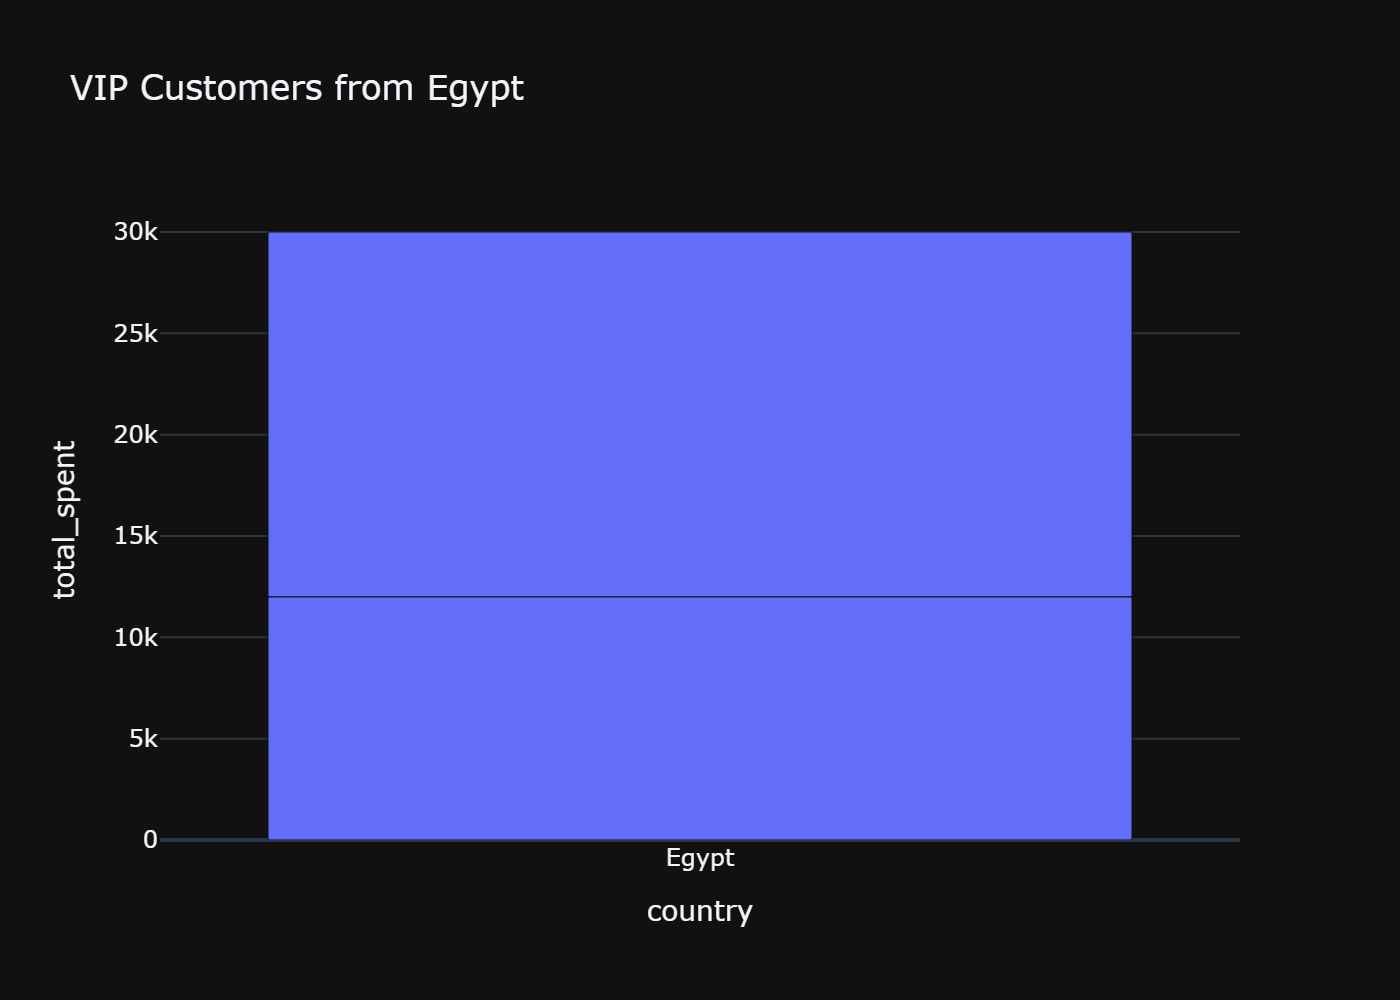

("SELECT * FROM customers WHERE country = 'Egypt' AND age > 40",    id           name  age country  total_spent
0   1       John Doe   45   Egypt      12000.0
1   3  Mohamed Salah   50   Egypt      18000.0, Figure({
    'data': [{'hovertemplate': 'country=%{x}<br>total_spent=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['Egypt', 'Egypt'], dtype=object),
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAABwx0AAAAAAAJTRQA==', 'dtype': 'f8'},
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'VIP Customers from Egypt'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], '

In [8]:
result = vn.ask(question="Show VIP customers from Egypt")
print(result)

###  Generating and executing SQL to return a DataFrame

This cell first generates an SQL query using the natural language question and the `schema_doc` for context.  
Then it runs the generated SQL against the connected SQLite database and returns the result as a pandas DataFrame.


In [9]:
sql = vn.generate_sql(
    question="Show VIP customers from Egypt",
    extra_doc=schema_doc
)

df = vn.run_sql(sql)
print(df)

WARNING	chromadb.segment.impl.vector.local_persistent_hnsw:local_persistent_hnsw.py:query_vectors()- Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
WARNING	chromadb.segment.impl.vector.local_persistent_hnsw:local_persistent_hnsw.py:query_vectors()- Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
WARNING	chromadb.segment.impl.vector.local_persistent_hnsw:local_persistent_hnsw.py:query_vectors()- Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1


SQL Prompt: [{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE customers (\n    id INTEGER PRIMARY KEY,\n    name TEXT,\n    age INTEGER,\n    country TEXT,\n    total_spent REAL\n)\n\n\n    CREATE TABLE customers (\n        id INT PRIMARY KEY,\n        name VARCHAR(100),\n        age INT,\n        country VARCHAR(50)\n    );\n\n\n\n===Additional Context \n\n\n    In our business, a VIP customer is someone whose age is over 40 and who lives in Egypt.\n\n\n\nWe have a table called 'customers' with the following columns:\n- id: unique customer ID\n- name: full name of the customer\n- age: age of the customer\n- country: customer's country\n- total_spent: total money the customer spent\n\nVIP customers are those who spent more than 10000 or are over 50 years old.\n\n\n===Response Gui